# HestonSLV 

- Example use of cppfm in Python
- Visualizing results from test_heston_slv.cpp and test_stoep.cpp

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cppfm

plt.style.use('seaborn-v0_8-whitegrid')
print('cppfm loaded successfully')

cppfm loaded successfully


Replicating calibration test: when the "market" is generated by Heston,
all four models (Market, LV, Heston, SLV) should produce identical implied volatilities.

**Key insight:** Since Market = Heston, the leverage function L(t,S) $\approx$ 1 everywhere.

In [30]:
# Van der Stoep Figure 4.1 Replication
# Andersen Case III / Van der Stoep (2014) Table 1 parameters

S0 = 1.0
r = 0.0
v0 = 0.0945
kappa = 1.05
vbar = 0.0855
sigma_v = 0.95  # gamma in the paper
rho = -0.315

discount = cppfm.FlatDiscountCurve(r)
heston = cppfm.HestonModel(S0, discount, v0, kappa, vbar, sigma_v, rho)

# Feller check
feller_lhs = 2 * kappa * vbar
feller_rhs = sigma_v ** 2
print(f'Feller check: 2κθ = {feller_lhs:.4f} vs γ² = {feller_rhs:.4f}')
print(f'Feller condition: {"SATISFIED" if feller_lhs >= feller_rhs else "VIOLATED (variance can hit zero)"}')

Feller check: 2κθ = 0.1796 vs γ² = 0.9025
Feller condition: VIOLATED (variance can hit zero)


WARNING [HestonModel]: Feller condition NOT satisfied!
  Required: 2*κ*v̄ ≥ σ²_v
  Current:  2*1.05*0.0855 = 0.17955 < σ²_v = 0.9025
  Implication: Variance process can reach zero.
  Use appropriate discretization schemes (BK/QE, BK/TG) that handle V->0.



In [ ]:
def compute_market_ivs(strikes, T):
    """Generate 'Market' IVs using COS method (the analytical Heston truth)"""
    ivs = []
    for K in strikes:
        price = cppfm.heston_call_price(S0, K, r, T, kappa, vbar, sigma_v, rho, v0)
        iv = cppfm.bs_implied_volatility(S0, K, r, T, price, cppfm.OptionType.Call)
        ivs.append(iv * 100)  # percentage
    return np.array(ivs)

def compute_mc_ivs(terminals, strikes, T):
    """Convert MC terminal spots to IVs"""
    df = np.exp(-r * T)
    ivs = []
    for K in strikes:
        payoffs = [max(s - K, 0.0) for s, _ in terminals]
        price = df * np.mean(payoffs)
        try:
            iv = cppfm.bs_implied_volatility(S0, K, r, T, price, cppfm.OptionType.Call)
            ivs.append(iv * 100)
        except:
            ivs.append(np.nan)
    return np.array(ivs)

def run_figure_41(T, strikes, num_paths=300000, num_time_steps=101, num_bins=50):
    """Twin experiment: Market = Heston, so SLV should match with L≈1"""
    time_steps = list(np.linspace(0, T, num_time_steps))

    # 1. MARKET: COS-based analytical Heston
    market_ivs = compute_market_ivs(strikes, T)
    print(f'T={T}: Market IVs computed (COS method)')

    # 2. HESTON MC: Pure Heston (no calibration, L computed single-pass)
    slv_heston = cppfm.HestonSLVSimulator(heston, time_steps, num_paths, num_bins=num_bins, seed=42)
    slv_heston.mixing_factor = 1.0
    terminals_heston = slv_heston.simulate(parallel=True)
    heston_ivs = compute_mc_ivs(terminals_heston, strikes, T)
    print(f'T={T}: Heston simulation done (η=1, uncalibrated)')

    # 3. SLV: Full SLV with calibrated leverage
    slv_full = cppfm.HestonSLVSimulator(heston, time_steps, num_paths, num_bins=num_bins, seed=42)
    slv_full.mixing_factor = 1.0
    n_iters = slv_full.calibrate_leverage(max_iters=15, tol=1e-4, damping=0.5)
    terminals_slv = slv_full.simulate(parallel=True)
    slv_ivs = compute_mc_ivs(terminals_slv, strikes, T)
    print(f'T={T}: SLV simulation done (η=1, calibrated in {n_iters} iters)')

    return market_ivs, heston_ivs, slv_ivs

In [ ]:
# Figure 4.1: T=2 (left) and T=8 (right)

# Strike ranges matching the paper
strikes_T2 = np.linspace(0.7, 1.5, 17)  # Left plot
strikes_T8 = np.linspace(0.5, 1.9, 15)  # Right plot (wider range for longer maturity)

print("Running T=2 experiment...")
market_2, heston_2, slv_2 = run_figure_41(T=2.0, strikes=strikes_T2, num_paths=300000, num_time_steps=201)

print("\nRunning T=8 experiment...")
market_8, heston_8, slv_8 = run_figure_41(T=8.0, strikes=strikes_T8, num_paths=300000, num_time_steps=401)

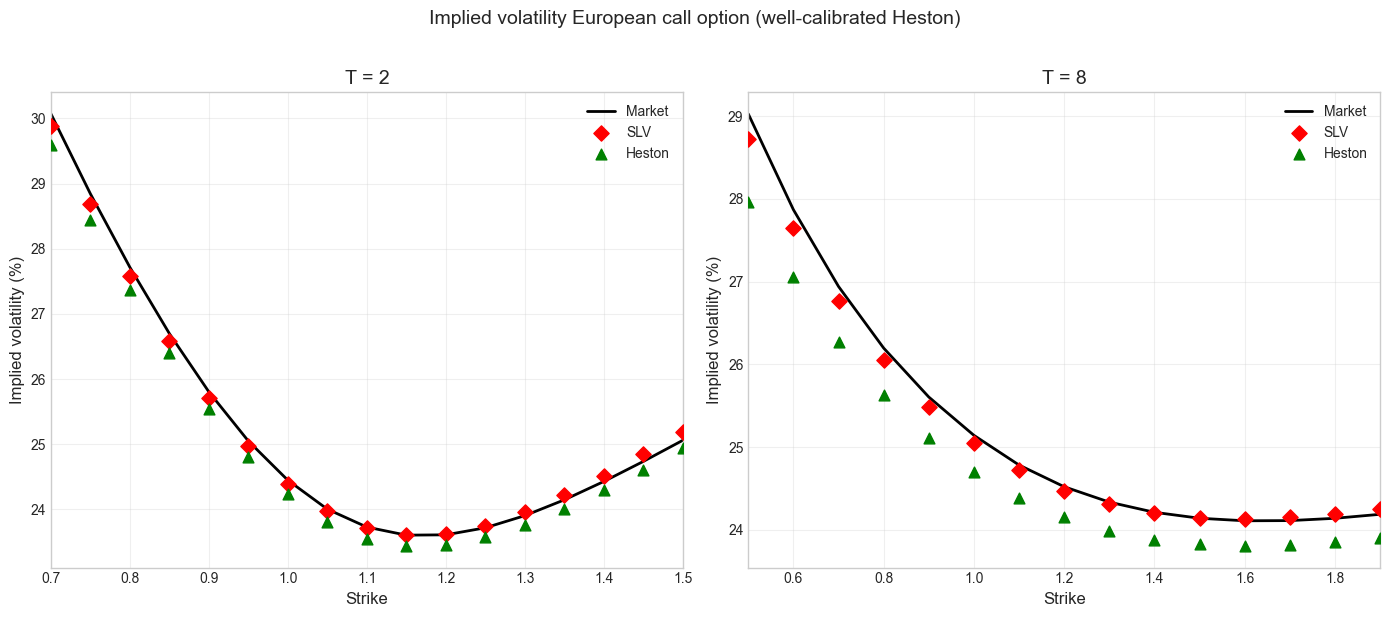


=== T=2 Comparison ===
  Strike     Market     Heston        SLV    Hes Err    SLV Err
    0.70      30.07      29.59      29.88      -47.9bp      -19.0bp
    0.90      25.80      25.53      25.71      -27.0bp       -9.0bp
    1.10      23.73      23.55      23.71      -17.7bp       -1.8bp
    1.30      23.90      23.77      23.96      -13.9bp       +5.2bp
    1.50      25.06      24.94      25.19      -12.0bp      +13.2bp

=== T=8 Comparison ===
  Strike     Market     Heston        SLV    Hes Err    SLV Err
    0.50      29.03      27.96      28.73     -106.7bp      -30.0bp
    0.90      25.61      25.11      25.49      -49.2bp      -11.5bp
    1.30      24.34      23.99      24.31      -34.7bp       -2.7bp
    1.70      24.11      23.82      24.15      -29.6bp       +3.8bp


In [15]:
# Plot Figure 4.1: "Well-calibrated Heston model"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# T=2 plot
ax1.plot(strikes_T2, market_2, 'k-', linewidth=2, label='Market')
ax1.scatter(strikes_T2, slv_2, c='red', marker='D', s=60, label='SLV', zorder=5)
ax1.scatter(strikes_T2, heston_2, c='green', marker='^', s=60, label='Heston', zorder=5)
ax1.set_xlabel('Strike', fontsize=12)
ax1.set_ylabel('Implied volatility (%)', fontsize=12)
ax1.set_title('T = 2', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0.7, 1.5])

# T=8 plot
ax2.plot(strikes_T8, market_8, 'k-', linewidth=2, label='Market')
ax2.scatter(strikes_T8, slv_8, c='red', marker='D', s=60, label='SLV', zorder=5)
ax2.scatter(strikes_T8, heston_8, c='green', marker='^', s=60, label='Heston', zorder=5)
ax2.set_xlabel('Strike', fontsize=12)
ax2.set_ylabel('Implied volatility (%)', fontsize=12)
ax2.set_title('T = 8', fontsize=14)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0.5, 1.9])


fig.suptitle('Implied volatility European call option (well-calibrated Heston)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print numerical comparison with errors
print('\n=== T=2 Comparison ===')
print(f'{"Strike":>8} {"Market":>10} {"Heston":>10} {"SLV":>10} {"Hes Err":>10} {"SLV Err":>10}')
for i in range(0, len(strikes_T2), 4):
    K = strikes_T2[i]
    hes_err = heston_2[i] - market_2[i]
    slv_err = slv_2[i] - market_2[i]
    print(f'{K:8.2f} {market_2[i]:10.2f} {heston_2[i]:10.2f} {slv_2[i]:10.2f} {hes_err*100:+10.1f}bp {slv_err*100:+10.1f}bp')

print('\n=== T=8 Comparison ===')
print(f'{"Strike":>8} {"Market":>10} {"Heston":>10} {"SLV":>10} {"Hes Err":>10} {"SLV Err":>10}')
for i in range(0, len(strikes_T8), 4):
    K = strikes_T8[i]
    hes_err = heston_8[i] - market_8[i]
    slv_err = slv_8[i] - market_8[i]
    print(f'{K:8.2f} {market_8[i]:10.2f} {heston_8[i]:10.2f} {slv_8[i]:10.2f} {hes_err*100:+10.1f}bp {slv_err*100:+10.1f}bp')

## SLV Convergence to Market

How does the leverage calibration progressively improve the IV fit? We run the calibration
step-by-step, measuring IV error at each iteration. In the twin experiment, the SLV should
converge to match Heston (our "market") as L(t,S) -> 1.

In [23]:
# Track IV error convergence during calibration
T_conv = 2.0
strikes_conv = np.linspace(0.7, 1.5, 13)
time_steps_conv = list(np.linspace(0, T_conv, 101))
num_paths_conv = 100000

# Market truth (COS method)
market_conv = compute_market_ivs(strikes_conv, T_conv)

# Storage for convergence data
iv_histories = []  # IV smile at each iteration
rmse_history = []
max_err_history = []

# Iteration 0: uncalibrated (single-pass leverage)
slv_conv = cppfm.HestonSLVSimulator(heston, time_steps_conv, num_paths_conv, num_bins=50, seed=42)
slv_conv.mixing_factor = 1.0
terminals = slv_conv.simulate(parallel=True)
ivs = compute_mc_ivs(terminals, strikes_conv, T_conv)
iv_histories.append(ivs.copy())
err = np.abs(ivs - market_conv) * 100  # bp
rmse_history.append(np.sqrt(np.mean(err**2)))
max_err_history.append(np.max(err))
print(f'Iter 0 (uncalibrated): RMSE={rmse_history[-1]:.2f}bp, Max={max_err_history[-1]:.1f}bp')

# Iterations 1-10: calibrate one step at a time
for i in range(1, 11):
    slv_conv.calibrate_leverage(max_iters=1, tol=0, damping=0.5)
    terminals = slv_conv.simulate(parallel=True)
    ivs = compute_mc_ivs(terminals, strikes_conv, T_conv)
    iv_histories.append(ivs.copy())
    err = np.abs(ivs - market_conv) * 100
    rmse_history.append(np.sqrt(np.mean(err**2)))
    max_err_history.append(np.max(err))
    print(f'Iter {i}: RMSE={rmse_history[-1]:.2f}bp, Max={max_err_history[-1]:.1f}bp')

Iter 0 (uncalibrated): RMSE=28.33bp, Max=49.9bp
Iter 1: RMSE=24.12bp, Max=44.9bp
Iter 2: RMSE=24.52bp, Max=44.3bp
Iter 3: RMSE=24.73bp, Max=44.0bp
Iter 4: RMSE=24.82bp, Max=43.8bp
Iter 5: RMSE=24.87bp, Max=43.7bp
Iter 6: RMSE=24.89bp, Max=43.6bp
Iter 7: RMSE=24.90bp, Max=43.6bp
Iter 8: RMSE=24.91bp, Max=43.6bp
Iter 9: RMSE=24.91bp, Max=43.6bp
Iter 10: RMSE=24.92bp, Max=43.6bp


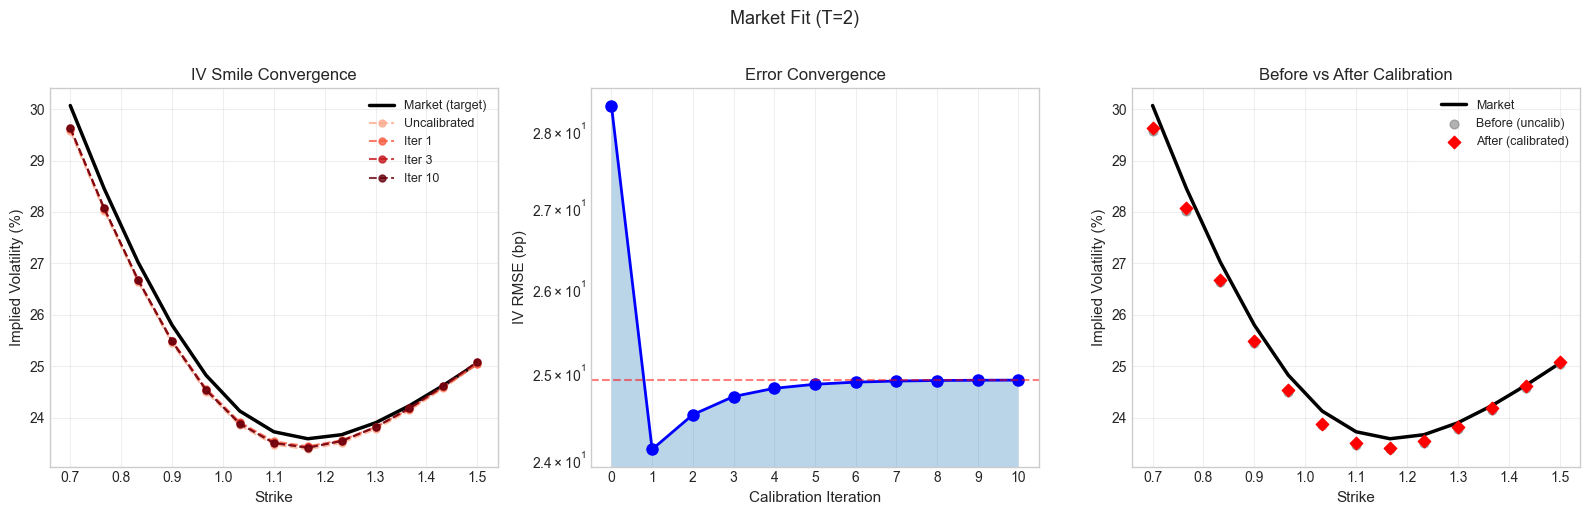


=== Calibration Summary ===
Initial RMSE: 28.33 bp
Final RMSE:   24.92 bp
Improvement:  12.0%
Max error:    49.9bp -> 43.6bp


In [27]:
# The Calibration Story: 3-panel visualization
fig = plt.figure(figsize=(16, 5))

# Panel 1: IV smile evolution (select iterations)
ax1 = fig.add_subplot(131)
ax1.plot(strikes_conv, market_conv, 'k-', linewidth=2.5, label='Market (target)')
colors = plt.cm.Reds(np.linspace(0.3, 1.0, 4))
for idx, (it, c) in enumerate(zip([0, 1, 3, 10], colors)):
    label = 'Uncalibrated' if it == 0 else f'Iter {it}'
    ax1.plot(strikes_conv, iv_histories[it], 'o--', color=c, markersize=5, alpha=0.8, label=label)
ax1.set_xlabel('Strike', fontsize=11)
ax1.set_ylabel('Implied Volatility (%)', fontsize=11)
ax1.set_title('IV Smile Convergence', fontsize=12)
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# Panel 2: RMSE convergence
ax2 = fig.add_subplot(132)
iters = list(range(len(rmse_history)))
ax2.semilogy(iters, rmse_history, 'bo-', linewidth=2, markersize=8)
ax2.fill_between(iters, rmse_history, alpha=0.3)
ax2.axhline(y=rmse_history[-1], color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Calibration Iteration', fontsize=11)
ax2.set_ylabel('IV RMSE (bp)', fontsize=11)
ax2.set_title('Error Convergence', fontsize=12)
ax2.set_xticks(iters)
ax2.grid(True, alpha=0.3)

# Panel 3: Before vs After
ax3 = fig.add_subplot(133)
ax3.plot(strikes_conv, market_conv, 'k-', linewidth=2.5, label='Market')
ax3.scatter(strikes_conv, iv_histories[0], c='gray', marker='o', s=40, alpha=0.6, label='Before (uncalib)', zorder=4)
ax3.scatter(strikes_conv, iv_histories[-1], c='red', marker='D', s=40, label='After (calibrated)', zorder=5)
ax3.set_xlabel('Strike', fontsize=11)
ax3.set_ylabel('Implied Volatility (%)', fontsize=11)
ax3.set_title('Before vs After Calibration', fontsize=12)
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)

fig.suptitle('Market Fit (T=2)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

print(f'\n=== Calibration Summary ===')
print(f'Initial RMSE: {init_rmse:.2f} bp')
print(f'Final RMSE:   {final_rmse:.2f} bp')  
print(f'Improvement:  {improvement:.1f}%')
print(f'Max error:    {max_err_history[0]:.1f}bp -> {max_err_history[-1]:.1f}bp')